In [289]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.special import factorial
import sympy as sp
import scipy as sc
from scipy.optimize import minimize_scalar

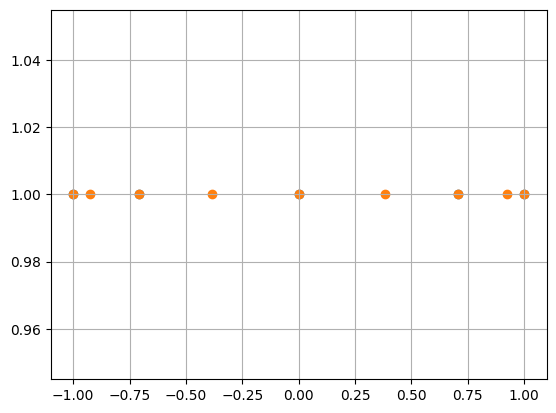

In [290]:

def nodess(k):

    # Extended Chebyshev nodes
    nodes = - np.cos(np.pi  * (2*np.arange(k+1) + 1 ) / (2*k + 2)) / np.cos(np.pi / (2*k + 2))

    # Augmented Chebyshev nodes
    nodes = np.cos((2 * np.arange(2, k + 2) - 3)*np.pi / (2 * (k)))

    # Chebyshev nodes
    nodes = np.cos(np.pi * (2*np.arange(1, k+2) - 1 ) / (2*(k + 1)))

    # Chebyshev nodes second kind
    nodes = np.cos(np.pi * (np.arange(1, k+2) - 1 ) / (k))
    plt.scatter(nodes, np.ones(len(nodes)))

t = np.linspace(-1, 1, 1000)
for k in [4, 8]:
    nodess(k)
plt.grid()
plt.show()

In [601]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M
        self.z = 1.96

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        # 
        #self.thetas = np.cos(np.pi * (2*np.arange(self.k+1) + 1 ) / (2*self.k + 2)) / np.cos(np.pi / (2*self.k + 2))


        self.f_hat_values = self.f_hat()
               
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        
        #fun = np.e**theta + 1
        
        fun = np.sin(theta) / theta + theta**2
        fun = np.cos(theta) - np.sin(theta) - 0.5
        #fun = np.e**(-theta**2)
        fun = np.cos(theta) + np.sin(theta)
        
        return fun

    
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(self.thetas, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_loss(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):
        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta

    def estimated_loss(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def optimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.min(g_values**2 - 2 * theta * g_values + theta**2, axis=0)
    
    def pessimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.max(g_values**2 - 2 * theta * g_values + theta**2, axis=0)

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):
        """
        Computes the sum of the absolute value of the Lagrange polynomials.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The sum of the absolute value of the Lagrange polynomials.
        """

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                (-1)**i * np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - np.cos(np.pi * (2*i + 1) / (2*self.k + 2)))
            )  

        #return np.sqrt(2 - 1 / (self.k + 1))
        return sum_new
       
    
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * self.z * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def bayes_ci(self, theta):
        lagrange_squared_sum = 0

        for i in range(self.k+1):

            lagrange_square = 1
            for j in range(self.k+1):
                if j != i:
                    lagrange_square = lagrange_square * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            lagrange_squared_sum += lagrange_square**2
            
        return self.z * self.sigma * np.sqrt(lagrange_squared_sum) / np.sqrt(self.n)

    def R(self, theta):

        prod = 1 
        for i in range(self.k+1):
            prod = prod * (theta - self.thetas[i])

        return np.abs(prod * self.M / math.factorial(self.k+1))
    
    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_loss(t)
        fs = self.true_loss(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'r--', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'g--', label=r"$\hat{g}(\theta)$")
        
        plt.plot(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), 'k--')
        plt.plot(t, self.g_hat(t) + self.R(t) + self.bayes_ci(t), 'k--', label="Confidence interval")
    
    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        plt.plot(t, self.true_loss(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_loss(t), 'C1--', label=f'estimated loss for k={self.k}')
        plt.fill_between(t,
                         self.optimistic_loss(t),
                         self.pessimistic_loss(t),
                         alpha=0.3,
                         color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(true_min, self.true_loss(true_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(estimated_min, self.true_loss(estimated_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")


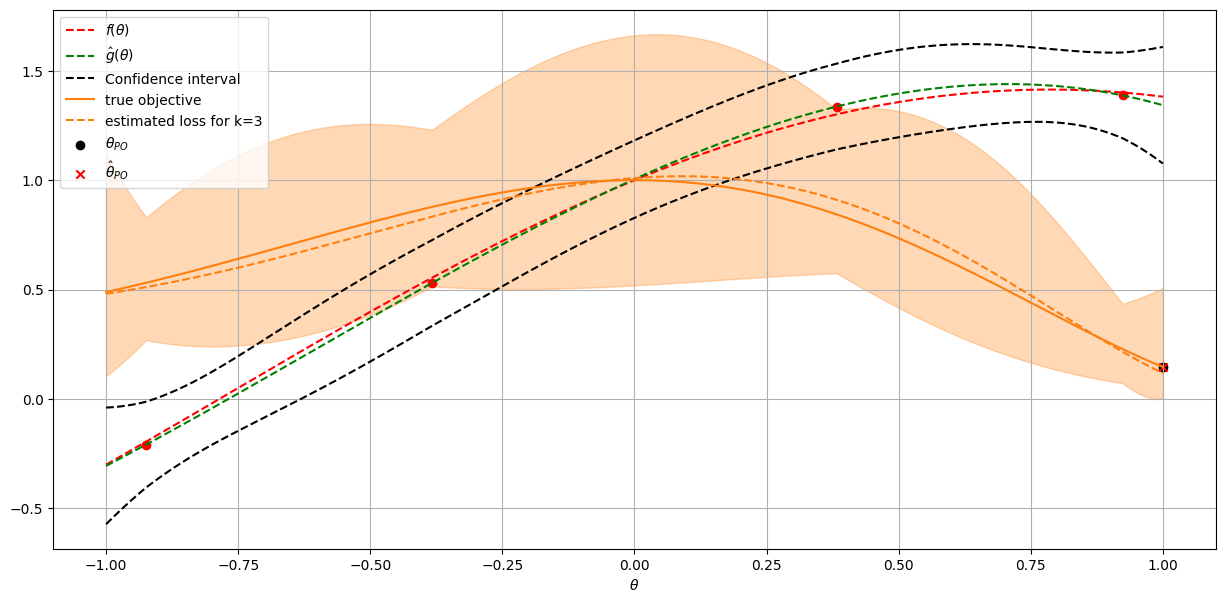

In [602]:
pr = Performative_Regression(k=3, n=1, T=1, sigma=0.1, M=np.sqrt(2))
plt.figure(figsize=(15, 7))
pr.plot_f_vs_g()
pr.plot_objectives()
for i in pr.thetas:
    plt.scatter(i, pr.g_hat(i), color='r')    
plt.grid()
plt.legend()
plt.show()

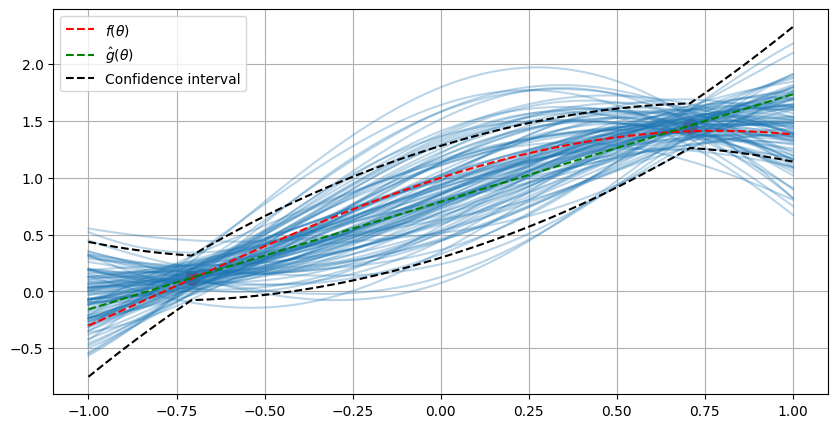

In [641]:
n = 1
sigma = 0.1
pr = Performative_Regression(k=1, n=n, T=1, sigma=sigma, M=np.sqrt(2))

toy_xp = np.linspace(-1., 1., 100)

# observed data
toy_X = pr.thetas
toy_y = pr.f_hat_values


rbf = RBF()
gp = GP(kernel=rbf)

# choose kernel hyper-params
theta = [1,  1]



yp = gp.predict(x_star=toy_xp, 
                X=toy_X, 
                y=toy_y, 
                size=100, 
                theta=theta, 
                sigma=sigma / np.sqrt(n))

# plot posterior draws and observations
fig = plt.figure(figsize=(10, 5))
plt.plot(toy_xp, np.transpose(yp), color="C0", alpha=0.3)



pr.plot_f_vs_g()

plt.scatter(toy_X, toy_y, color='red', s=100)
plt.legend()
plt.grid()
plt.show()

In [295]:
class Adaptive_Chebyshev_Interpolation:

    def __init__(self, K, M=1, sigma=0.1):
        """
        K - even
        """
        self.sigma = sigma
        self.M = M
        self.K = K

        # Initialize possible nodes (Chebyshev K+1)
        self.all_nodes = np.cos(np.pi * (2*np.arange(1, self.K+2) - 1 ) / (2*(self.K + 1)))

        self.used_nodes = {node : 0 for node in self.all_nodes}

        self.f_estimates = {self.all_nodes[(self.K + 1) // 2] : self.observation(self.all_nodes[(self.K + 1) // 2])}

    def f(self, theta):

        fun = np.cos(theta) - np.sin(theta) + 3
        
        return fun
    
    def observation(self, node):

        return np.random.normal(self.f(node), self.sigma)

    def step(self):

        new_node = 1

        # Estimate g(x) using the estimate of f at the nodes
        
        # Compute lower bound of (g_hat(x) - x)^2

        # Take new_node = argmin(LB((g_hat(x) - x)^2))

        # Update the nodes by adding the new node (unless new_node is already in nodes)

    


In [296]:
ai = Adaptive_Chebyshev_Interpolation(K=10)
ai.f_estimates

{2.83276944882399e-16: 3.9736152268323144}

In [548]:
class GP:
  def __init__(self, kernel: callable):
    """
    Args:
      kernel:
      prior_mean:
    """
    self.k = kernel

  def predict(
      self, 
      x_star, 
      X: np.array=None, 
      y: np.array=None, 
      size: int=1,
      theta: list=None,
      sigma: float=0.,
    ):
    """
    Given observations (X, y) and test points x_star, fit a GP model
    and draw posterior samples for f(x_star) from the fitted model.

    Args:
      x_star: (n*,) array of feature values at which predictions
        for f(x_star) will be made.
      X: (n,) observed features.
      y: (n,) observed response variables.
      size: number of posterior samples drawn.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      y_star: (size, n*) array of posterior samples for f(y_star).
    """
    # 1. compute 
    # k(x*, X)
    k_xs_x = self.k(x_star, X, theta) # m x n
    # k(X, x*)
    k_x_xs = np.transpose(k_xs_x) # n x m
    # k(x*, x*)
    k_xs_xs = self.k(x_star, x_star, theta) # m x m
    # k(X, X) + sigma^2 I_n
    k_x_x = self.k(X, X, theta) # n x n
    cov_x_x = k_x_x + sigma**2 * np.eye(len(X))

    # 2. compute posterior means and covariance matrix
    posterior_mean = np.matmul(k_xs_x,
                               np.linalg.solve(cov_x_x, y))

    posterior_var = (k_xs_xs - np.matmul(k_xs_x, 
                                         np.linalg.solve(cov_x_x, k_x_xs)))

    # # add jitter for numerical stability
    # posterior_var += 1e-18 * np.eye(posterior_var.shape[0])

    self.posterior_mean = posterior_mean
    self.posterior_var = posterior_var

    # 3. draw posterior samples by using the posterior
    # mean and covariance matrix
    y_star = np.random.multivariate_normal(
        mean=self.posterior_mean,
        cov=self.posterior_var,
        size=size,
    )

    return y_star

  def marginal_loglik(self, X, y, theta: list=None, sigma: float=0.):
    """
    Given observations (X, y), compute the marginal loglikelihood
    of a GP model.

    Args:
      X: (n,) observed features.
      y: (n,) observed response variables.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      log_lik: marginal loglikelihood at (X, y).
    """

    k_x_x = self.k(X, X, theta) # n, n
    cov_x_x = k_x_x + sigma**2 * np.eye(len(X)) # n, n

    data_fit = -0.5 * np.matmul(
        y,
        np.linalg.solve(cov_x_x, y), # n,
    )
    _, log_det = np.linalg.slogdet(cov_x_x)
    penalty = - 0.5 * log_det

    log_lik = data_fit + penalty

    return log_lik

In [516]:
class Kernel:
  def __init__(self):
    pass

  def __call__(self, x, y, theta: list=None):
    raise NotImplementedError()

class RBF(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Given an input array x of size n and another input array y of 
    size m, compute the n by m kernel matrix whose (i, j)-th entry 
    is k(x_i, y_j).

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    self.theta1, self.theta2 = theta

    diff = np.expand_dims(x, 1) - np.expand_dims(y, 0)  # nx1 - 1xm = nxm
    k_mat = self.theta1**2 * np.exp( - 1 / (2 * self.theta2**2) * diff**2)

    return k_mat

In [559]:
def optim_hyperparams(init_params, data_X, data_y, gp, method="CG", maxiter=60):
  """
  Find the best kernel hyper-parameters that maximise the log marginal
  likelihood.
  """
  # define negative log marginal likelihood as objective
  # input is unpacked to theta and sigma
  objective = lambda params: -gp.marginal_loglik(
    data_X, data_y, theta=params[:-1], sigma=params[-1],
  )

  optim_res = minimize(
      fun=value_and_grad(objective),
      jac=True,
      x0=init_params, 
      method=method,
      options={"return_all": True, "maxiter": maxiter},
  )
  return optim_res

In [563]:
import autograd.numpy as np
from autograd import value_and_grad
import pandas as pd
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt

init_params = [1., 1., 0.1]
otpim_res = optim_hyperparams(init_params=init_params, data_X=toy_X, data_y=toy_y, gp=gp)
otpim_res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.8516157437855127
       x: [ 1.461e+00  1.475e+00 -1.070e-08]
     nit: 24
     jac: [ 1.892e-06  7.132e-07 -2.144e-06]
    nfev: 52
    njev: 52
 allvecs: [array([ 1.000e+00,  1.000e+00,  1.000e-01]), array([ 9.840e-01,  1.022e+00,  5.720e-03]), array([ 9.795e-01,  1.086e+00, -1.059e-02]), array([ 1.011e+00,  1.137e+00,  9.934e-03]), array([ 1.233e+00,  1.301e+00, -1.876e-02]), array([ 1.394e+00,  1.420e+00, -5.539e-03]), array([ 1.394e+00,  1.421e+00, -5.795e-04]), array([ 1.394e+00,  1.421e+00,  2.858e-04]), array([ 1.394e+00,  1.430e+00, -3.779e-04]), array([ 1.394e+00,  1.431e+00,  1.563e-04]), array([ 1.420e+00,  1.454e+00, -7.518e-04]), array([ 1.427e+00,  1.459e+00,  5.030e-04]), array([ 1.453e+00,  1.475e+00,  1.228e-03]), array([ 1.463e+00,  1.480e+00, -1.499e-05]), array([ 1.465e+00,  1.478e+00,  1.220e-04]), array([ 1.465e+00,  1.478e+00, -1.358e-06]), array([ 1.464e+00,  1.477e+00,  2.6